In [1]:
import numpy as np
import matplotlib.pylab as plt
from IPython.display import display
import pandas as pd
import seaborn as sns

### Index

[Task 1: Regression](#Task-1:-Regression)

[1.1 Linear regression](#1.1-Linear-regression)  

[1.2 Ridge regression](#1.2-Ridge-regression)

[1.3 Regression with k nearest neighbours](#1.3-Regression-with-k-nearest-neighbours)

[Task 2: Classification](#Task-2:-Classification)

[2.1 Logistic regression](#2.1-Logistic-regression)

[2.2 Random forest](#2.2-Random-forest)

[2.3 Support vector machines](#2.3-Support-vector-machines)

# Task 1: Regression

We first read the data set an define the name of the columns, we have 404 observations and 19 variables, including the first variable that is 1 for every row

In [196]:
RTrain = pd.read_csv('regression_train.csv',header=None)
RTrain.columns = [f'x{i+1}' for i in range(RTrain.shape[1]-1)] + ['y']
display(RTrain.head())
print(RTrain.shape)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,y
0,1.0,-0.413447,-0.487722,0.115738,0.115735,0.158124,0.984960,0.797449,-0.773684,0.985161,-0.803212,1.176466,0.441052,-0.983048,0.158124,1.176469,-0.487723,-0.773598,23.9
1,1.0,-0.412788,-0.487722,-1.034027,-1.034035,-0.386091,0.819700,0.207144,-0.418203,0.819617,-0.666608,-0.857929,0.379323,-0.803625,-0.386091,-0.857939,-0.487723,-0.418305,29.9
2,1.0,-0.387983,-0.487722,-0.211099,-0.211084,0.261784,-0.510932,-0.923682,-0.671859,-0.511320,-0.102376,0.344213,0.441052,0.131334,0.261784,0.344218,-0.487727,-0.671863,24.5
3,1.0,-0.347952,-0.487722,-0.720322,-0.720323,-0.412006,0.846768,0.324494,-0.248591,0.846699,-0.601276,-0.488039,0.369674,-0.381702,-0.412006,-0.488023,-0.487722,-0.248524,27.5
4,1.0,-0.330562,-0.487722,-0.437258,-0.437249,-0.144217,0.299699,0.918355,0.313581,0.299802,-0.601276,1.176466,0.342811,0.020597,-0.144217,1.176460,-0.487724,0.313542,18.4


(404, 19)


If we analyze the distribution of the variables we find the next set of histograms, we can see that the pairs $(x_7,x_{10})$ and $(x_6,x_{14}$) and $(x_9, x_{18})$ have a very similar distribution

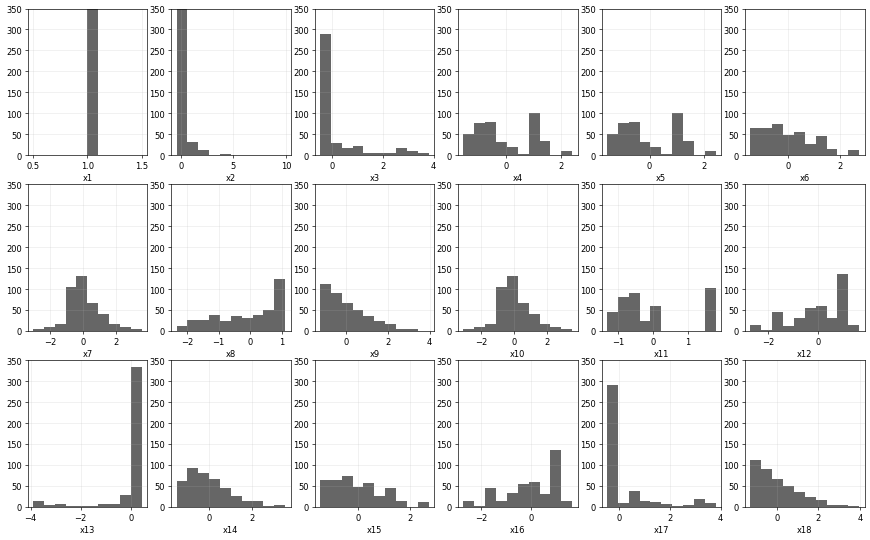

In [197]:
fig, axs = plt.subplots(3,6, figsize=(18, 11), facecolor='w', edgecolor='k',dpi=60)
axs = axs.ravel()
for i,col in enumerate(RTrain.columns[:-1]):
    axs[i].hist(RTrain[col],color='red'*(col=='y') + 'black'*(col!='y'),alpha=0.6)
    axs[i].set_xlabel(col)
    axs[i].set_ylim(0,350)
    axs[i].grid(alpha=0.25)

If we compute the correlation we can see that the pairs are completely correlated 

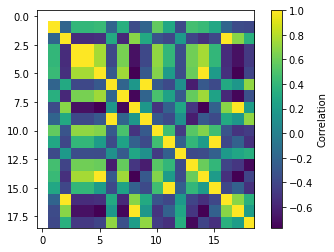

In [198]:
fig, ax = plt.subplots(1,1)
img= plt.imshow(RTrain.corr())
fig.colorbar(img,label='Correlation')

In [199]:
RTest = pd.read_csv('regression_test.csv',header=None)
RTest.columns = [f'x{i+1}' for i in range(RTest.shape[1]-1)] + ['y']

In [200]:
X  = np.array(RTrain[[col for col in RTrain.columns if col[0] == 'x']])
y  = np.array(RTrain['y'])
Xt = np.array(RTest[[col for col in RTest.columns if col[0] == 'x']])
yt = np.array(RTest['y'])

## 1.1 Linear regression

We define the functions in order to perform the regression and the metrics needed

In [2]:
def standardise(X):
    """
    Standarize a set of variables and 
    returns the values of the mean and
    the standard deviation
    
    :param X :     a DxN numpy array
    
    :return X_std: a DxN numpy array - standarize matrix
    :return mu:    a Nx1 numpy array - mean
    :return std:   a Nx1 numpy array - standard deviation 
    """
    mu = np.mean(X,axis=0)
    std = np.std(X,axis=0)
    return (X-mu)/std, mu,std 
def MSE(y1,y2):
    """
    Computes the Mean Square Error
    of a pair of vectors y1, y2
    
    :param y1 :  a mx1 numpy array
    :param y2 :  a mx1 numpy array
    
    :return mse: a float - MSE
    """
    return(sum((y1 - y2)**2)/ len(y2))
def R2(y1,y2):
    """
    Computes the R^2 score
    of a pair of vectors y1, y2
    
    :param y1 : a mx1 numpy array
    :param y2 : a mx1 numpy array
    
    :return r2: a float - R2
    """
    return(1- sum((y1 - y2)**2)/sum((y1 - np.mean(y1))**2))
def max_lik_estimate(X, y):
    """
    Computes the the parameter beta maximizing 
    the likelihood of the parameter
    
    :param X : an NxD numpy array 
    :param y : an Nx1 numpy array 
    
    :return beta_ml: an Dx1 numpy array - Estimated parameter
    """
    N, D = X.shape
    beta = np.zeros((D, 1)) 
    beta_ml = np.linalg.solve(X.T @ X ,X.T @ y) 
    
    return beta_ml
def predict_with_estimate(X, beta):
    """
    Computes the prediction of a given the
    estimation of beta and the observations
    
    :param X :    an NxD numpy array
    :param beta : an Dx1 numpy array    
    
    :return y_pred: an Nx1 numpy array - Prediction
    """
    N, D = X.shape
    y_pred = X @ beta
    
    return y_pred 

In [202]:
X_std = X.copy()
X_std[:,1:],mu,std = standardise(X_std[:,1:])

Xt_std = Xt.copy()
Xt_std[:,1:] = (Xt_std[:,1:] - mu) / std

beta = max_lik_estimate(X_std, y)
for i,b in enumerate(beta):
    print(f"β_{i} = {b:.2f}")

β_0 = 23.02
β_1 = -0.64
β_2 = -47996.91
β_3 = -40007.85
β_4 = 40007.69
β_5 = 927163399.35
β_6 = 984.82
β_7 = -0.16
β_8 = 1589.80
β_9 = -981.70
β_10 = -0.05
β_11 = -6047.61
β_12 = 0.70
β_13 = -3.69
β_14 = -927163401.12
β_15 = 6045.82
β_16 = 47998.12
β_17 = -1593.35


The parameters have very different sizes although we standarize the variables, we can also see that the correlated variables cancel each other, for example $\beta_5$ and $\beta_{14}$ 

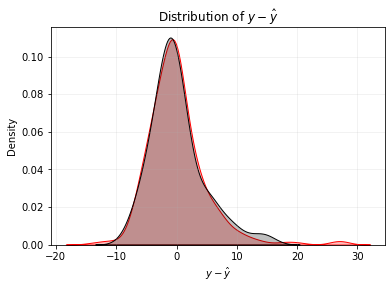

In [203]:
y_hat = predict_with_estimate(X_std,beta)
yt_hat = predict_with_estimate(Xt_std,beta)
_ = sns.kdeplot((y - y_hat),fill=True,color='red')
_ = sns.kdeplot((yt - yt_hat),fill=True,color='k')
_ = plt.title("Distribution of $y-\hat{y}$")
_ = plt.grid(alpha=0.2)
_ = plt.xlabel('$y-\hat{y}$')

We compute the prediction of the complete data set used for training and the data set for testing.

In [204]:
MSE_train = MSE(y,y_hat)
MSE_test  = MSE(yt,yt_hat)
R2_train = R2(y,y_hat)
R2_test = R2(yt,yt_hat)
print(f"MSE in train data = {MSE_train:.3f}")
print(f"MSE in test data  = {MSE_test:.3f}")
print(f"R2 in train data  = {100*R2_train:.3f}%")
print(f"R2 in test data   = {100*R2_test:.3f}%")

MSE in train data = 24.369
MSE in test data  = 19.567
R2 in train data  = 72.858%
R2 in test data   = 66.570%


The mean square error for the training is higher than for the testing dataset, that mean that the model is not overfitting the data in the sense that it can produces predictions as good as the one in the observable dataset for training.

## 1.2 Ridge regression

In [72]:
def ridge_estimate(X, y, penalty):
    """
    Computes the optimal beta given 
    the penalty and the observation 
    data X, y
    
    :param X : an NxD numpy array
    :param y : an Nx1 numpy array  
    :param penalty: a float
    
    :return beta_ridge: an Dx1 numpy array - Estimated parameter
    """
    N, D = X.shape
    I = np.identity(D)
    beta_ridge = np.linalg.solve(X.T @ X + penalty * I, X.T @ y )
    return beta_ridge
def data_split(X,y,T):
    """
    Split the data into T random
    subsets of almost equal size

    :param X : an NxD numpy array
    :param y : an Nx1 numpy array  
    :param T:  a integer
    
    :return Xs: a list of T NxD numpy arrays - List of partitions of X
    :return ys: a list of T Nx1 numpy arrays - List of partitions of y
    """
    N, D = X.shape
    R = np.random.randint(low=0,high=T,size=N)
    Xs = [X[R==i,:] for i in range(T)]
    ys = [y[R==i] for i in range(T)]
    return(Xs,ys)
def cv_penalty(X,y,T,penalties):
    """
    Split the data into T random 
    subsets of almost equal size and
    computes the cross validation of 
    each of the folds, it computes the 
    optimal penalty for the ridge linear
    regression given a list of posible 
    penalties

    :param X : an NxD numpy array
    :param y : an Nx1 numpy array  
    :param T:  a integer
    :param penalties: a Px1 numpy array
    
    :return op_penalties: a float
    :return mse_penalty: a Px1 numpy array
    """
    np.random.seed(100)
    Xs,ys = data_split(X,y,T)
    mse_penalty = []
    for p in penalties:
        mse_s = []
        for t in range(T):
            Xcs = np.concatenate([x for i,x in enumerate(Xs) if i !=t])
            ycs = np.concatenate([y for i,y in enumerate(ys) if i !=t])
            Xcs_std = Xcs.copy()
            Xcs_std[:,1:],mu,std = standardise(Xcs_std[:,1:])

            beta_t = ridge_estimate(Xcs_std,ycs,penalty=p)

            Xs_std = Xs[t].copy()
            Xs_std[:,1:] = (Xs_std[:,1:] - mu) / std  

            ycs_hat = predict_with_estimate(Xs_std,beta_t)

            mse_s.append(MSE(ys[t],ycs_hat))
        mse_penalty.append(np.mean(mse_s))
        
    return(penalties[np.argmin(mse_penalty)],mse_penalty)

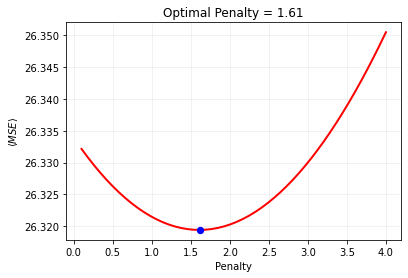

In [206]:
T = 5
penalties = np.linspace(0.1,4)
op_penalty,mse_penalty = cv_penalty(X,y,T,penalties)
_ = plt.plot(penalties,mse_penalty,color='red',lw=2)
_ = plt.grid(alpha=0.2)
_ = plt.scatter([op_penalty],[min(mse_penalty)],zorder=10,s=40,color='b')
_ = plt.title(f"Optimal Penalty = {op_penalty:.2f}")
_ = plt.xlabel("Penalty")
_ = plt.ylabel('$\langle MSE \\rangle$')

In [207]:
beta = ridge_estimate(X,y,penalty=op_penalty)
for i,b in enumerate(beta):
    print(f"β_{i} = {b:.2f}")

β_0 = 22.44
β_1 = -0.64
β_2 = 0.57
β_3 = -0.10
β_4 = -0.10
β_5 = -0.84
β_6 = 1.58
β_7 = -0.15
β_8 = -1.73
β_9 = 1.56
β_10 = -0.09
β_11 = -0.87
β_12 = 0.82
β_13 = -3.63
β_14 = -0.84
β_15 = -0.87
β_16 = 0.57
β_17 = -1.73


We compute the prediction of the complete data set used for training and the data set for testing.

In [208]:
y_hat = predict_with_estimate(X,beta)
yt_hat = predict_with_estimate(Xt,beta)
MSE_train = MSE(y,y_hat)
MSE_test  = MSE(yt,yt_hat)
R2_train = R2(y,y_hat)
R2_test = R2(yt,yt_hat)
print(f"MSE in train data = {MSE_train:.3f}")
print(f"MSE in test data  = {MSE_test:.3f}")
print(f"R2 in train data  = {100*R2_train:.3f}%")
print(f"R2 in test data   = {100*R2_test:.3f}%")

MSE in train data = 24.563
MSE in test data  = 19.363
R2 in train data  = 72.643%
R2 in test data   = 66.918%


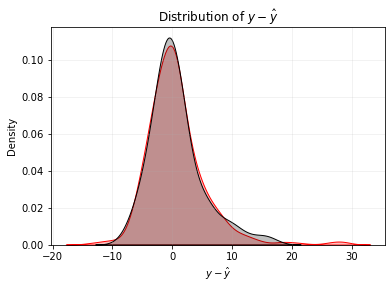

In [209]:
y_hat = predict_with_estimate(X_std,beta)
yt_hat = predict_with_estimate(Xt_std,beta)
_ = sns.kdeplot((y - y_hat),fill=True,color='red')
_ = sns.kdeplot((yt - yt_hat),fill=True,color='k')
_ = plt.title("Distribution of $y-\hat{y}$")
_ = plt.grid(alpha=0.2)
_ = plt.xlabel('$y-\hat{y}$')

The optimal penalty is 1.61, with that penalty we don't have a significant change with respect to the original linear regression, nonetheless we see a signigicant change in the estimators, they are smaller and have similar magnitudes. The errors among the test and the train data are normally distributed as we can see. 

<a id='1.3 Regression with k nearest neighbours'></a>
## 1.3 Regression with k nearest neighbours

In [210]:
X  = np.array(RTrain[[col for col in RTrain.columns if col[0] == 'x']])
y  = np.array(RTrain['y'])
Xt = np.array(RTest[[col for col in RTest.columns if col[0] == 'x']])
yt = np.array(RTest['y'])
X = X[:,1:]
Xt = Xt[:,1:]

In [211]:
def euclidian_distance(p, q):
    """
    Computes the distance between two points
    
    :param p: an nx1 numpy array
    :param q: an nx1 numpy array
    
    :return distance: a float
    """
    distance = np.sqrt(np.sum((p-q)**2, axis=1))
    return distance
def k_neighbours(X,X_train, n_neighbours=5):
    """
    Computes the k closest points for a data set
    X given the information of the training 
    data set X_train
    
    :param X: an NxD numpy array
    :param X_train: an MxD numpy array
    :param n_neighbours: an integer 
    
    :return neigh_ind: a N lenght list of arrays
    """        
    dist = []
    neigh_ind = []

    point_dist = [euclidian_distance(x_test, X_train) for x_test in X]
    
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:n_neighbours]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    return np.array(neigh_ind)
def reg_predict(X_test,X_train, y_train, n_neighbours=20):
    """
    Computes the prediction of a dataset X_test
    given the model obtained by X_train and y_train
    
    :param X_test: an NxD numpy array
    :param X_train: an MxD numpy array
    :param y_train: an Mx1 numpy array
    :param n_neighbours: an integer 
    
    :return y_pred: an Nx1 numpy array
    """   
    neighbours = k_neighbours(X_test,X_train, n_neighbours)
    
    y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours]) ## <-- SOLUTION

    return y_pred
def cv_kneighbours(X,y,T,k_values):
    """
    Finds the best selection of k for the 
    data set X,y using T-folds
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param k_values: a list of P integers
    
    :return op_k: an integer
    :return mse_k: a list of P floats
    """       
    np.random.seed(100)
    Xs,ys = data_split(X,y,T)
    mse_k = []
    mse_k2 = []
    for k in k_values:
        mse_s = []
        mse_s2 = []
        for t in range(T):
            Xs[t],ys[t]
            Xcs = np.concatenate([x for i,x in enumerate(Xs) if i !=t])
            ycs = np.concatenate([y for i,y in enumerate(ys) if i !=t])
            Xcs_std = Xcs.copy()
            Xcs_std, mu, std = standardise(Xcs)

            Xs_std = Xs[t].copy()
            Xs_std = (Xs_std - mu) / std


            ycs_hat = reg_predict(Xs_std,Xcs_std,ycs, n_neighbours = k)
            
            ycs2_hat = reg_predict(Xcs_std,Xcs_std,ycs, n_neighbours = k) #We compute the prediction of the data itself
            
            mse_s.append(MSE(ys[t],ycs_hat))
            mse_s2.append(MSE(ycs,ycs2_hat)) # The prediction of the data itself

        mse_k2.append(np.mean(mse_s2))
        mse_k.append(np.mean(mse_s))
    op_k = k_values[np.argmin(mse_k)]
    return(op_k,mse_k,mse_k2)

In [212]:
T = 5 
k_values = np.arange(1,20,1)
op_k,mse_k,mse_k2 = cv_kneighbours(X,y,T,k_values)

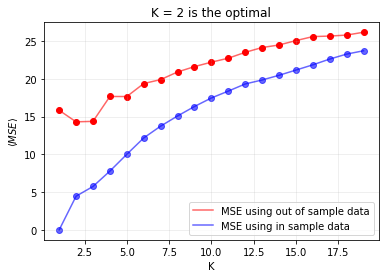

In [213]:
_ = plt.scatter(k_values,mse_k,color='red')
_ = plt.scatter(k_values,mse_k2,color='blue',alpha=0.6)
_ = plt.plot(k_values,mse_k,color='red',alpha=0.6,label='MSE using out of sample data')
_ = plt.plot(k_values,mse_k2,color='blue',alpha=0.6,label='MSE using in sample data')
_ = plt.grid(alpha=0.25)
_ = plt.title(f"K = {op_k} is the optimal")
_ = plt.xlabel("K")
_ = plt.legend()
_ = plt.ylabel('$\langle MSE \\rangle$')

In [214]:
X_std = X.copy()
Xt_std = Xt.copy()
X_std,mu,std  = standardise(X_std)
Xt_std = (Xt_std - mu) / std
y_hat  = reg_predict(X_std,X_std,y, n_neighbours=op_k)
yt_hat = reg_predict(Xt_std,X_std,y, n_neighbours=op_k)
MSE_train = MSE(y,y_hat)
MSE_test  = MSE(yt,yt_hat)
R2_train = R2(y,y_hat)
R2_test = R2(yt,yt_hat)
print(f"MSE in train data = {MSE_train:.3f}")
print(f"MSE in test data  = {MSE_test:.3f}")
print(f"R2 in train data  = {100*R2_train:.2f}%")
print(f"R2 in test data   = {100*R2_test:.2f}%")

MSE in train data = 3.971
MSE in test data  = 13.764
R2 in train data  = 95.58%
R2 in test data   = 76.48%


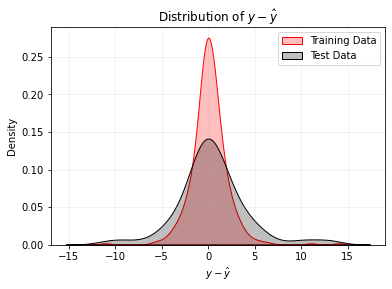

In [215]:
_ = sns.kdeplot((y - y_hat),fill=True,color='red',label='Training Data')
_ = sns.kdeplot((yt - yt_hat),fill=True,color='k',label='Test Data')
_ = plt.title("Distribution of $y-\hat{y}$")
_ = plt.grid(alpha=0.2)
_ = plt.xlabel('$y-\hat{y}$')
_ = plt.legend()

#### Conclusions 

We found that the optimal number of neighbours is 2, nonetheless we found a great overfitting using a few number of neighbours, we can see that from the MSE of the testing data, we can also see that from the distribution of the errors, for the training data the errors are very concentrated, the errors for the test data are more spread. We also compute the MSE in the cross valitation for the predictions of the data itself (data used for the model) and we can see in the figure that the spread between the MSEs is bigger in low values of k (overfitting). That would suggest that using the MSE of the cross valitation is not the best way to find the parameter, if we select a number of neighbours of 15 we get a closer MSE between the training and the less, but we loss some accuracy: 

MSE in train data = 19.431
MSE in test data  = 15.072
R2 in train data  = 78.36%
R2 in test data   = 74.25%


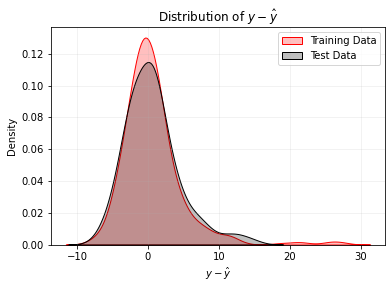

In [216]:
X_std = X.copy()
Xt_std = Xt.copy()
X_std,mu,std  = standardise(X_std)
Xt_std = (Xt_std - mu) / std
y_hat  = reg_predict(X_std,X_std,y, n_neighbours=15)
yt_hat = reg_predict(Xt_std,X_std,y, n_neighbours=15)
MSE_train = MSE(y,y_hat)
MSE_test  = MSE(yt,yt_hat)
R2_train = R2(y,y_hat)
R2_test = R2(yt,yt_hat)
print(f"MSE in train data = {MSE_train:.3f}")
print(f"MSE in test data  = {MSE_test:.3f}")
print(f"R2 in train data  = {100*R2_train:.2f}%")
print(f"R2 in test data   = {100*R2_test:.2f}%")
_ = sns.kdeplot((y - y_hat),fill=True,color='red',label='Training Data')
_ = sns.kdeplot((yt - yt_hat),fill=True,color='k',label='Test Data')
_ = plt.title("Distribution of $y-\hat{y}$")
_ = plt.grid(alpha=0.2)
_ = plt.xlabel('$y-\hat{y}$')
_ = plt.legend()

The performance of the model is similar in both training an test dataset

<a id='Task 2: Classification'></a>
# Task 2: Classification

In [217]:
CTrain = pd.read_csv('classification_train.csv',header=None)
CTrain.columns = [f'x{i+1}' for i in range(CTrain.shape[1]-1)] + ['y']
display(CTrain.head())
print(CTrain.shape)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,y
0,0.161765,0.25,0.363156,0.25,0.0,0.000000,0.333333,0.333333,0.267857,1.000000,1.0,0.0
1,0.470588,0.50,0.858754,0.00,0.0,0.333333,0.666667,0.666667,0.428571,1.000000,0.0,1.0
2,0.117647,0.00,0.138054,0.00,1.0,0.333333,1.000000,0.333333,0.267857,0.666667,0.0,1.0
3,0.470588,0.50,0.175856,0.00,1.0,1.000000,0.333333,0.666667,0.410714,0.666667,0.0,0.0
4,0.647059,0.00,0.239628,0.00,1.0,0.666667,1.000000,1.000000,0.089286,0.666667,0.0,0.0


(800, 12)


In [218]:
CTest = pd.read_csv('classification_test.csv',header=None)
CTest.columns = [f'x{i+1}' for i in range(CTest.shape[1]-1)] + ['y']
display(CTest.head())
print(CTest.shape)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,y
0,0.205882,0.50,0.069055,0.0,0.5,1.000000,0.333333,1.000000,0.232143,1.000000,1.0,1.0
1,0.382353,0.00,0.238418,0.0,0.5,0.333333,0.333333,0.000000,0.232143,0.666667,0.0,1.0
2,0.558824,1.00,0.208650,0.5,0.5,1.000000,1.000000,0.000000,0.303571,0.666667,1.0,1.0
3,0.338235,0.00,0.277484,0.0,0.0,0.333333,1.000000,0.333333,0.553571,0.666667,1.0,0.0
4,0.250000,0.75,0.115715,0.0,0.5,0.000000,1.000000,0.333333,0.500000,0.666667,0.0,1.0


(200, 12)


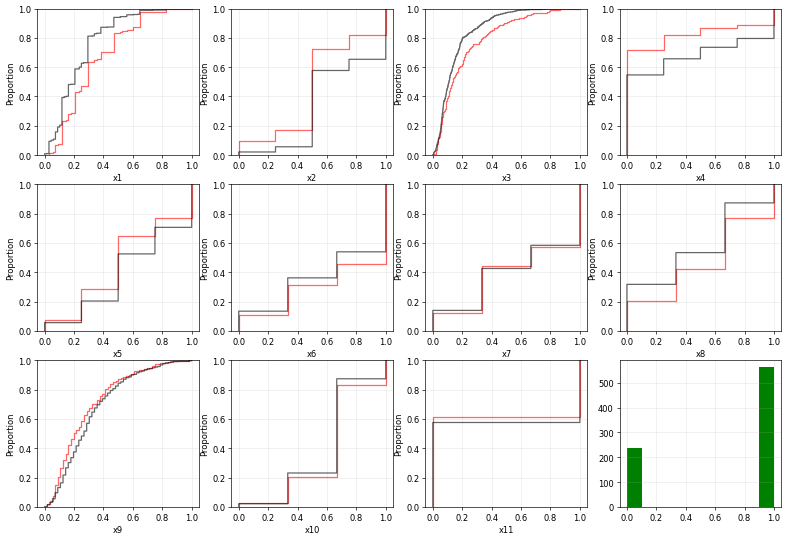

In [219]:
fig, axs = plt.subplots(3,4, figsize=(16, 11), facecolor='w', edgecolor='k',dpi=60)
axs = axs.ravel()
for i,col in enumerate(CTrain.columns):
    if col != 'y':
        sns.ecdfplot(CTrain[CTrain.y == 0][col],color='red',alpha=0.6,ax=axs[i])
        sns.ecdfplot(CTrain[CTrain.y == 1][col],color='k',alpha=0.6,ax=axs[i])
        axs[i].set_xlabel(col)
        axs[i].grid(alpha=0.25)
    else:
        plt.hist(CTrain[col],color='g')
        axs[i].grid(alpha=0.25)

We draw the cumulative histogram of the variables, we would like to see some separation between the 2 classes in y variable 

<a id='2.1 Logistic regression'></a>
## 2.1 Logistic regression

In [220]:
X  = np.array(CTrain[[col for col in CTrain.columns if col[0] == 'x']]).T
y  = np.array(CTrain['y'])
Xt = np.array(CTest[[col for col in CTest.columns if col[0] == 'x']]).T
yt = np.array(CTest['y'])

In [1189]:
def logistic(x):
    """
    Logistic function
    
    :param x: a float
    
    :return log: a float
    """
    return(1/(1+np.exp(-x)))
def predict_log(X, beta, beta_0):
    """
    Probability given the Logistic model
    for X, beta and beta_0
    
    :param x: a DxM numpy array
    :param beta: a Dx1 numpy array
    :param beta_0: a float
    
    :return y_log: a float
    """
    y_log = logistic(beta.T @ X + beta_0)
    return y_log
def propagate(X, y, beta, beta_0):
    """
    Compute the cost and the derivatives requiered
    for the optimization of the problem 
    
    :param X: a dxn numpy array
    :param y: a nx1 numpy array
    :param beta: a Dx1 numpy array
    :param beta_0: a float

    :return grads: a Dx1 numpy array
    :return cost: a float
    """
    n = X.shape[1]
    y_log = predict_log(X, beta, beta_0)

    cost = (-1) * np.mean(np.multiply(y, np.log(y_log)) + np.multiply(1-y, np.log(1 - y_log)), axis=1) 

    dbeta = (1/n) * X @ np.transpose(y_log - y)  
    dbeta_0 =  np.mean((y_log - y))

    assert(dbeta.shape==beta.shape)
    assert(dbeta_0.dtype==float)
    cost = np.squeeze(cost)
    assert(cost.shape==())

    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}

    return grads, cost

def optimise(X, y, num_iterations=1000, learning_rate=0.005, print_cost=False):
    """
    Compute the optimization for the dataset X,y
    returns the optimal parameters

    :params X: a dxn numpy array
    :params y: a nx1 numpy array
    :params num_iterations: a integer 
    :params learning_rate: a float 
    :params print_cost: a boolean 
    
    :return params: a dictionary 
    :return grads: a dictionary 
    :return costs: a list 
    """
    d = X.shape[0]
    
    beta = np.zeros(shape=(d, 1), dtype=np.float32)
    beta_0 = 0
    
    costs = []

    for i in range(num_iterations):

        grads, cost = propagate(X, y, beta, beta_0) 

        dbeta = grads["dbeta"]
        dbeta_0 = grads["dbeta_0"]

        beta = beta - learning_rate * dbeta
        beta_0 = beta_0 - learning_rate * dbeta_0

    if i % 100 == 0:
        costs.append(cost)

    if print_cost and i % 100 == 0:
        print ("cost after iteration %i: %f" %(i, cost))
  
    params = {"beta": beta, "beta_0": beta_0}
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}

    return params, grads, costs
def predict(X_test, beta, beta_0,threshold):
    """
    Computes the prediction of the data X_test
    given the parameters beta, beta_0 and decides 
    the classification with the threshold given
    
    :param X_test: an dxm numpy array
    :param beta: an dx1 numpy array
    :param beta_0: a float
    :param threshold: a float
    
    :return y_pred: a mx1 numpy array
    """
    n = X_test.shape[1]
    y_pred = np.zeros((1,n))
    beta = beta.reshape(X_test.shape[0], 1)

    y_log = predict_log(X_test, beta, beta_0)

    for i in range(y_log.shape[1]):
        
        if y_log[0, i] > threshold:
            y_pred[0, i] = 1  
        else:
            y_pred[0, i] = 0  

    assert(y_pred.shape==(1, n))

    return y_pred[0]
def accuracy(y1,y2):
    """
    Accuracy of a classification problem
    
    :param y1: a nx1 numpy array
    :param y2: a nx1 numpy array
    
    :return acc: a float
    """
    acc = 1 - np.mean(np.abs(y1 - y2))
    return acc 
def score(y1,y2):
    """
    Score/Accuracy of a binary classification problem
    
    :param y1: a nx1 numpy array
    :param y2: a nx1 numpy array
    
    :return score: a float
    """
    score = sum(y1 == y2) / len(y1)
    return score
def confusion_matrix(y1,y2):
    """
    Confusion matrix for the predictions 
    y1 and y2
    
    :param y1: a nx1 numpy array
    :param y2: a nx1 numpy array
    
    :return CM: a 2x2 numpy array
    """
    
    TP,FN,TN,FP= 0,0,0,0
    for i in range(len(y1)):
        if y1[i] == 1:
            if y2[i] == 1:
                TP += 1
            else:
                FN +=1
        else:
            if y2[i] == 1:
                FP += 1
            else:
                TN += 1   
    return(np.array([[TP,FP],[FN,TN]]))
def F1score(y1,y2):
    """
    F1 score for the predictions 
    y1 and y2
    
    :param y1: a nx1 numpy array
    :param y2: a nx1 numpy array
    
    :return F1: a 2x2 numpy array
    """    
    TP = 0
    for i in range(len(y1)):
        if (y1[i] == 1) and (y2[i] == 1):
            TP += 1 
    precision = TP / len(y1)
    recall = TP/ (sum(y2 == 1)+0.000001)
    
    F1 = 2*(precision * recall) / (precision + recall+0.000001)
    return(F1)

def cv_logistic(X,y,T,hypergrid,num_iterations=5000):
    """Finds the best selection of hyperparameters
    for the data set X,y using T-folds for the 
    logistic model classification
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param hypergrid: a dictionary with parameters
    :param num_iterations: a integer 
    
    :return op_params: a tuple 
    :return Results: a LxJ numpy array
    """       
    np.random.seed(100)
    Xs,ys = data_split(X.T,y,T)
    Xs = [xs.T for xs in Xs]
    Results = np.zeros((len(hypergrid['threshold']),len(hypergrid['learning_rate'])))
    Params = [(x,y) for x in hypergrid['threshold'] for y in hypergrid['learning_rate']]
    for i,threshold in enumerate(hypergrid['threshold']):
        for j,learning_rate in  enumerate(hypergrid['learning_rate']):
            acc_s = []
            for t in range(T):
                Xcs = np.concatenate([x.T for i,x in enumerate(Xs) if i!=t]).T
                ycs = np.concatenate([y for i,y in enumerate(ys) if i!=t])              
                
                
                parameters, _, _ = optimise(Xcs, ycs, num_iterations, learning_rate=learning_rate)
                beta = parameters["beta"]
                beta_0 = parameters["beta_0"]
                ycs_hat = predict(Xs[t], beta, beta_0,threshold)       
                acc_s.append(accuracy(ys[t],ycs_hat))
            Results[i,j] = np.mean(acc_s) 
            
    b_index = np.argmax(Results)
    return(Params[np.argmax(Results)], Results)   

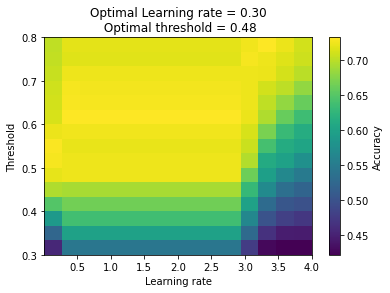

In [222]:
hypergrid = {'threshold':np.linspace(0.3,0.8,15),'learning_rate':np.linspace(0.01,4,15)}
(op_threshold, op_learning_rate), Results  = cv_logistic(X,y,T=5,hypergrid=hypergrid,num_iterations=5000)

fig, ax = plt.subplots(1,1)
img = ax.imshow(Results,extent=[hypergrid['learning_rate'].min(), 
                                hypergrid['learning_rate'].max(), 
                                hypergrid['threshold'].min(), 
                                hypergrid['threshold'].max()], aspect='auto')
_ = fig.colorbar(img,label='Accuracy')
_ = plt.title(f"Optimal Learning rate = {op_learning_rate:.2f}\n Optimal threshold = {op_threshold:.2f}")
_ = ax.set_xlabel("Learning rate")
_ = ax.set_ylabel("Threshold")

In [223]:
parameters, _, _ = optimise(X, y, num_iterations=5000, learning_rate=op_learning_rate)
beta = parameters["beta"]
beta_0 = parameters["beta_0"]
y_hat = predict(X, beta, beta_0,op_threshold)
yt_hat = predict(Xt, beta, beta_0,op_threshold)

print(f"Accuracy Training = {100*accuracy(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*accuracy(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Accuracy Training = 75.00%
Accuracy Test     = 73.50%
F1 Training = 70.81%
F1 Test     = 69.15%
Confusion matrix Training = 
 [[530  70]
 [ 33 167]]
Confusion matrix Test = 
 [[130  17]
 [  7  46]]


The model get a good result of 75% accuracy in the training set and 73.5% in the test (not used) data. It's a good sign that the difference between both accuracies is low

## 2.2 Random forest

The implementation of the random forest is based on the implementation of individual decision trees, each of this implementation trees splits the data into binary areas, it uses the cross entropy to compute the best split.

We use the function <code>entropy_impurity</code> to compute the best split with <code>best_split</code> in the function <code>build_tree</code> we use the parameter num_features which limits the maximun number of variables that are considered in each step. The function <code>probability</code> computes the probability of being in the class 1 given each leaf.

The function <code>best_split</code> takes into account the number of unique values of the variable and determines if it is discrete or continuous.

Finally the function <code>random_forest</code> create a tree for the resample of the data. The prediction of the $B$ different number of tree is computed using <code>predict_forest</code>.

The cross-validation is perfomed over the number of trees, the maximum depth of the tree and the number of predictors in each split

In [41]:
X  = np.array(CTrain[[col for col in CTrain.columns if col[0] == 'x']])
y  = np.array(CTrain['y'])
Xt = np.array(CTest[[col for col in CTest.columns if col[0] == 'x']])
yt = np.array(CTest['y'])

In [42]:
def entropy_impurity(y):
    """ 
    Calculate the gini impurity for labels.
    
    :param y: a nx1 numpy array
    
    :returns entropy: a float 
    """
    sample_weights = np.ones(y.shape[0]) / y.shape[0]

    entropy = 0
    num = y.shape[0]
    label_counts = {}
    for i in range(num):
        if y[i] not in label_counts.keys():
            label_counts[y[i]] = 0
        label_counts[y[i]] += sample_weights[i]

    for key in label_counts:
        prob = float(label_counts[key]) / float(np.sum(sample_weights))
        entropy -= prob * (np.log(prob))

    return entropy
def best_split(X,y):
    """
    Computes the best split for the data
    an the classification variable y 
    it returns the best split in a 
    pair (j,s)
    
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    
    :return best: a tuple - (j,s) variable and split
    """
    min_entropy =1
    for column in range(X.shape[1]):
        s = 0
        if len(np.unique(X[:, column]) < 30): # For discrete variable 
            unique_vals = np.unique(X[:, column])
        else: #For continuous variables
            unique_vals = np.quantile(X[:, column],q=np.linspace(0,1,10))
        for val in unique_vals:
            sub1_X,sub2_X, sub1_y,sub2_y = split_dataset(X, y, column, val)
            prob1,prob2 = len(sub1_y) / len(y) ,  len(sub2_y) / len(y)
            entropy = prob1 * entropy_impurity(sub1_y)  + prob2*entropy_impurity(sub2_y) 
            if entropy < min_entropy:
                min_entropy = entropy
                best = (column,val)
    return(best)
def split_dataset(X, y, column, value):
    """
    Compute the split of the data set (X,y)
    given the column and the value 
   
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param column: a integer - the column of the feature for splitting
    :param value: a float - the value of the split

    :return sub1_X: a DxN1 numpy array - Upper split of X
    :return sub2_X: a DxN2 numpy array - Lower split of X
    :return sub1_y: a N1x1 numpy array - Upper split of y 
    :return sub2_y: a N2x1 numpy array - Lower split of y 
    """ 
    ret = []
    comp = []
    for i in range(len(X)):
        if X[i, column]<=value:
            ret.append(i)
        else:
            comp.append(i)

    sub1_X = X[ret,:]
    sub1_y = y[ret]
    sub2_X = X[comp,:]
    sub2_y = y[comp]

    return sub1_X,sub2_X, sub1_y,sub2_y

def probability(y):
    """
    Return the probability of y == 0  
    
    :param y: a Nx1 numpy array
    
    :return probability: a float
    """
    
    probability = sum(y == 1) / len(y)

    return probability

def build_tree(X, y, feature_names, depth,num_features, max_depth=10, min_samples_leaf=10):
    """ 
    Build the decision tree according to the data.
    
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param feature_names: a list - names of the variables 
    :param depth: a integer - current depth for this node.
    :param num_features: a integer - number of features to use 
    :param max_depth: a integer
    :param min_samples_leaf: a integer 
    
    :return tree: a dict - "node" -> "leaf" -> "right/left" -> majority_vote
    """
    mytree = dict()

    if len(y) ==0:
        mytree = { 'node':'leaf' ,  'label': 0 }
    elif len(feature_names)==0 or len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        mytree = { 'node':'leaf' ,  'label': probability(y) }
    else:  
        P_hat = np.random.choice(range(X.shape[1]),size = num_features,replace=False)
        best_feature_idx, value = best_split(X[:,P_hat],y)
        best_feature_idx = P_hat[best_feature_idx]
        best_feature_name = feature_names[best_feature_idx]
        sub1_X,sub2_X, sub1_y,sub2_y = split_dataset(X, y, best_feature_idx, value)
        mytree = { 'node':'split', 'feature_name':best_feature_name, 'value':value }
        mytree['left']  = build_tree(sub1_X, sub1_y, feature_names, depth+1,num_features,max_depth,min_samples_leaf) 
        mytree['right'] = build_tree(sub2_X, sub2_y, feature_names, depth+1,num_features,max_depth,min_samples_leaf) 

    return mytree
def classify_proba(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    
    :param x: a Nx1 dataframe 
    
    :return class: a integer - predicted testing sample label.
    """
    if tree['node'] == 'leaf':
        return tree['label']
    else:
        feature_name = tree['feature_name']
        v = x[feature_name]
    if (v <= tree['value']):
        return classify_proba(tree['left'],x)
    else:
        return classify_proba(tree['right'],x)
def predict_proba(tree,X):
    """
    Predict classification results for X.
    
    :param X: a DxN numpy array    
    
    :return results: a Nx1 numpy array
    """
    if len(X.shape)==1:
        return classify_proba(tree, X)
    else:
        results=[]
        for i in range(X.shape[0]):
            results.append(classify_proba(tree, X.iloc[i, :]))
        return np.array(results)
def random_forest(X,y,n_trees,feature_names,depth,num_features,max_depth,min_samples_leaf):
    """
    Computes n_trees resampling the data for
    each computation, returns a list of all the 
    trees build
    
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param n_trees: a integer
    :param feature_names: a list - names of the variables 
    :param depth: a integer - current depth for this node.
    :param num_features: a integer - number of features to use 
    :param max_depth: a integer
    :param min_samples_leaf: a integer 
    
    :return forest: a list of dicts - each dict is a tree    
    """   
    N = len(X)
    forest = []
    for b in range(n_trees):
        b_index = np.random.choice(range(N),size = N)
        X_b = X[b_index,:]
        y_b = y[b_index]
        forest.append(build_tree(X_b, y_b, feature_names, depth,num_features,max_depth,min_samples_leaf))
    return(forest)
def predict_proba_forest(X,forest):
    """
    Predict the value of a data set
    X given the forest
    
    :param X: a DxN numpy array
    :param forest: a list - of dicts corresponding of trees
    
    :return y: a Nx1 numpy array
    """    
    D, N = X.shape
    y_pred = []    
    forest_pred = []
    for tree in forest:
        forest_pred.append(predict_proba(tree,X))
    
    y_pred = np.mean(np.array(forest_pred),axis=0)
    return(y_pred)
def predict_forest(X,forest):
    """
    Predict the value of a data set
    X given the forest
    
    :param X: a DxN numpy array
    :param forest: a list - of dicts corresponding of trees
    
    :return y: a Nx1 numpy array
    """    
    y_proba = predict_proba_forest(X,forest)
    y_pred = np.round(y_proba)
    
    return(y_pred)
def cv_randomforest(X,y,T,hypergrid):
    """Finds the best selection of hyperparameters
    for the data set X,y using T-folds for the 
    random forest model classification
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param hypergrid: a dictionary with parameters
    
    :return op_params: a tuple - the 3 optimal parameters
    :return Results: a LxJ numpy array
    :return op_index: a tuple - the index of the optimal result
    """     
    Xs,ys = data_split(X,y,T)
    Results = np.zeros((len(hypergrid['max_depth']),len(hypergrid['num_features']),len(hypergrid['num_trees'])))
    Params = [(x,y,z) for x in hypergrid['max_depth'] for y in hypergrid['num_features'] for z in hypergrid['num_trees']]
    Params = np.array(Params)
    for i,max_depth in enumerate(hypergrid['max_depth']):
        for j,num_features in enumerate(hypergrid['num_features']):
            for k,num_trees in enumerate(hypergrid['num_trees']):
                acc_s = []
                for t in range(T):
                    Xcs = np.concatenate([x for i,x in enumerate(Xs) if i!=t])
                    ycs = np.concatenate([y for i,y in enumerate(ys) if i!=t])
                    Trees = random_forest(Xcs,ycs,num_trees,list(CTrain.columns),depth=1, num_features=num_features,
                                            max_depth=max_depth,min_samples_leaf=3)
                    ycs_hat =predict_forest(pd.DataFrame(Xs[t],columns=CTrain.columns[:-1]),Trees)
                    acc_s.append(accuracy(ys[t],ycs_hat))
                Results[i,j,k] = np.mean(acc_s) 
    
    op_index = np.unravel_index(np.argmax(Results),shape=Results.shape)      
    
    return(Params[np.argmax(Results)],Results,op_index)

In [226]:
%%time
hypergrid = {'max_depth':[5,8,10],'num_features':[3,4,5,7],'num_trees':[1,5,10,20,50]}
(op_max_depth, op_num_features, op_num_trees),Results,op_index =  cv_randomforest(X,y,5,hypergrid)
print(f"Optimal max depth = {op_max_depth}")
print(f"Optimal num features = {op_num_features}")
print(f"Optimal num trees = {op_num_trees}")
print(f'Maximum accuracy = {100*Results[op_index]:.2f}%')

Optimal max depth = 8
Optimal num features = 7
Optimal num trees = 50
Maximum accuracy = 74.19%
Wall time: 1h 6min 42s


In [43]:
forest = random_forest(X,y,op_num_trees,list(CTrain.columns),depth=1,num_features=op_num_features,
                            max_depth=op_max_depth,min_samples_leaf=3)
y_hat =  predict_forest(pd.DataFrame(X,columns=CTrain.columns[:-1]),forest)
yt_hat = predict_forest(pd.DataFrame(Xt,columns=CTrain.columns[:-1]),forest)
print(f"Accuracy Training = {100*accuracy(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*accuracy(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Accuracy Training = 85.88%
Accuracy Test     = 76.50%
F1 Training = 76.22%
F1 Test     = 70.74%
Confusion matrix Training = 
 [[561 111]
 [  2 126]]
Confusion matrix Test = 
 [[133  43]
 [  4  20]]


We found an accuracy of 77% in the test dataset, with a best result of 86% in the training set, the computation time for this functio took an hour and 6 minutes, that's the reason for not looking for more parameters in the hypergrid. 

## 2.3 Support vector machines

In [44]:
CTrain = pd.read_csv('classification_train.csv',header=None)
CTrain.columns = [f'x{i+1}' for i in range(CTrain.shape[1]-1)] + ['y']
CTest = pd.read_csv('classification_test.csv',header=None)
CTest.columns = [f'x{i+1}' for i in range(CTest.shape[1]-1)] + ['y']


X = CTrain[[col for col in CTrain.columns if col[0] == 'x']]
y = CTrain['y'].map({0:-1,1:1})

Xt = CTest[[col for col in CTrain.columns if col[0] == 'x']]
yt = CTest['y'].map({0:-1,1:1})

N = X.shape[0]

X_std = X.copy()

X_std,mu,std = standardise(X_std)
Xt_std = (Xt - mu) / std

X_std.insert(loc= len(X_std.columns),  column='intercept', value=1)
Xt_std.insert(loc=len(Xt_std.columns), column='intercept', value=1)

X.insert(loc= len(X.columns),  column='intercept', value=1)
Xt.insert(loc=len(Xt.columns), column='intercept', value=1)

### 2.3.1 Hard Margin Linear SVM 

We can compute the hard margin linear SVM by aproximating using the soft margin. If we let the regulation parameter $\lambda$ be very large then the cost of missclasification is stronger and the resulting model is closer to the hard margin model.

In [45]:
def compute_cost(W, X, y, regul_strength=1e5):
    """
    Computes the cost of the parameters W
    given the data X,y and the regulation
    strength 
    
    :param W: a Dx1 numpy array
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param regul_strength: a float
    
    :return cost: a float
    """
    n = X.shape[0]
    distances = 1 - y * (np.dot(X, W)) 
    distances[distances < 0] = 0 
    hinge = regul_strength * (np.sum(distances) / n) 

    cost = 1 / 2 * np.dot(W, W) + hinge
    return cost
def calculate_cost_gradient(W, X, y, regul_strength=1e5):
    """
    Compute the gradient of the cost 
    function given the value of the parameter
    and the data.
    
    :param W: a Dx1 numpy array
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param regul_strength: a float
    
    :return dw: a Dx1 numpy array
    """
    
    if type(y) == np.int64:
        y = np.asarray([y])
        X = np.asarray([X])  
    distance = 1 - (y * np.dot(X, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = W
        else:
            di = W - (regul_strength * y[ind] * X[ind])
        dw += di

    dw = dw/len(y)
    return dw

def linear_svm_sgd(X, y, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e5, print_outcome=False):
    """
    Computes the optimal parameter W using 
    stochastic gradient descent for the data X,y, 
    and given the learning rate, regulation strength 
    parameter, stop criterion and the maximun number 
    of iterations
    
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param max_iterations: a integer
    :param stop criterion: a float
    :param learning_rate: a float
    :param regul_strength: a float
    :param print_outcome: a boolean
    
    :return weights: a Dx1 numpy parameter    
    """
    weights = np.zeros(X.shape[1])
    nth = 0

    prev_cost = np.inf

    for iteration in range(1, max_iterations):
        np.random.shuffle([X, y])
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, y[ind], regul_strength) 
            weights = weights - (learning_rate * ascent)

        if iteration==2**nth or iteration==max_iterations-1:

            cost = compute_cost(weights, X, y, regul_strength) 
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))

            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
          
            prev_cost = cost
            nth += 1
  
    return weights
def predict_svm(W,X):
    """ 
    Given a array of parameters W computes
    the prediction for the dataset X
    
    :param W: a Dx1 numpy array
    :param X: a NxD numpya array
    
    :return y_pred: a Nx1 numpy array
    """
    
    y_preds = np.array([])
    for i in range(X.shape[0]):
        y_pred = np.sign(np.dot(X[i], W))
        y_preds = np.append(y_preds, y_pred)
    return(np.array(y_preds))

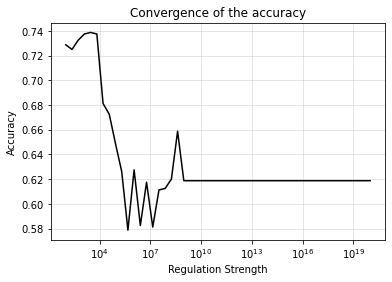

In [386]:
acc = []
for i in np.linspace(2,20):
    W = linear_svm_sgd(np.array(X_std), np.array(y), max_iterations=200,regul_strength=10**i)
    y_hat  = predict_svm(W,np.array(X_std))
    acc.append(score(y,y_hat))
_ = plt.plot(10 ** np.linspace(2,20) ,acc,color='k')
_ = plt.xscale("log")
_ = plt.ylabel("Accuracy")
_ = plt.xlabel("Regulation Strength")
_ = plt.title("Convergence of the accuracy")
_ = plt.grid(alpha=0.4)

In order to verify that the regulation strength is big enough we run the algorithm for big values of the parameter and compute the prediction and accuracy with each of them, we would like to find convergenge in the predictions.
We don't find convergence in the estimated parameters, they increase as the parameter increase, we can see that for a parameter bigger than $10^{10}$ there is no change in the accuracy

In [46]:
W = linear_svm_sgd(np.array(X_std), np.array(y), max_iterations=1000,regul_strength=1e10)
y_hat  = predict_svm(W,np.array(X_std))
yt_hat = predict_svm(W,np.array(Xt_std))
print(f"Accuracy Training = {100*score(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*score(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Accuracy Training = 61.75%
Accuracy Test     = 64.00%
F1 Training = 58.45%
F1 Test     = 60.18%
Confusion matrix Training = 
 [[382 125]
 [181 112]]
Confusion matrix Test = 
 [[102  37]
 [ 35  26]]


We find that the result standarizing the data is not very good, we ran the model using the non-standarize data: 

In [164]:
W = linear_svm_sgd(np.array(X), np.array(y), max_iterations=1000,regul_strength=1e10)
y_hat  = predict_svm(W,np.array(X))
yt_hat = predict_svm(W,np.array(Xt))
print(f"Accuracy Training = {100*score(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*score(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Accuracy Training = 70.88%
Accuracy Test     = 68.50%
F1 Training = 70.55%
F1 Test     = 68.50%
Confusion matrix Training = 
 [[563 233]
 [  0   4]]
Confusion matrix Test = 
 [[137  63]
 [  0   0]]


We get a best result, nonetheless in the confussion matrix we can see that is classifying almost everything on 1, we could fix that by modifying the parameter $b$ we train the model over $W$ and then we do cross validation to find the optimal value for $b$

In [185]:
def cv_linearsvm(X,y,T,hypergrid):
    """Finds the best parameter b
    given the data X,y and the number of
    folds T 
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param hypergrid: a dictionary with parameters
    
    :return op_params: a tuple - the 3 optimal parameters
    :return Results: a LxJ numpy array
    """     
    Xs,ys = data_split(X,y,T)
    Results = []
    Params = np.array(hypergrid['b'])
    
    
    for t in range(T):
        Xcs = np.concatenate([x for i,x in enumerate(Xs) if i!=t])
        ycs = np.concatenate([y for i,y in enumerate(ys) if i!=t])
        W = linear_svm_sgd(Xcs, ycs, max_iterations=1000,regul_strength=1e10)
        acc_s = []
        for k,b in enumerate(hypergrid['b']):
            W[-1] = b 
            ycs_hat = predict_svm(W,np.array(Xs[t]))
            acc_s.append(F1score(ys[t],ycs_hat))
        Results.append(acc_s)
    
#     op_index = np.argmax(Results)
    
    return(Results)

Text(0, 0.5, '$F_1$ Score')

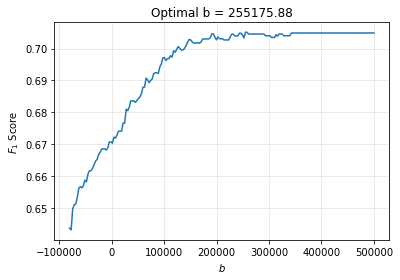

In [198]:
hypergrid = {'b':np.linspace(-80000,500000,200)}
Results = cv_linearsvm(np.array(X),np.array(y),5,hypergrid)
accuracies = np.array(Results).mean(axis=0) 
op_b = hypergrid['b'][np.argmax(accuracies)]
plt.plot(hypergrid['b'],accuracies)
plt.title(f"Optimal b = {op_b:.2f}")
plt.xlabel('$b$')
plt.grid(alpha=0.3)
plt.ylabel("$F_1$ Score")

In [202]:
W = linear_svm_sgd(np.array(X), np.array(y), max_iterations=1000,regul_strength=1e10)
print(W[-1])
W[-1] = op_b #replace by the optimal 
y_hat  = predict_svm(W,np.array(X))
yt_hat = predict_svm(W,np.array(Xt))
print(f"Accuracy Training = {100*score(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*score(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

168649.09006649622
Accuracy Training = 70.50%
Accuracy Test     = 68.50%
F1 Training = 70.42%
F1 Test     = 68.50%
Confusion matrix Training = 
 [[563 236]
 [  0   1]]
Confusion matrix Test = 
 [[137  63]
 [  0   0]]


The result was not very succesful, most classification goes to one, the more we increase $b$ the more positive the function $\langle X_i, W \rangle$ is

### 2.3.1 Hard Margin RBF SVM 

The formulation of the linear SVM is to solve the following problem 
$$\min_{\omega \in \mathbb{R}^d}\frac{1}{2}\| \omega \|^2  \text{ subject to } y_i \langle x_i , \omega \rangle \geq 1 \text{ for } i = 1,...,N$$ 
The Lagrange (primal) function, to be minimized w.r.t. $\omega$ is
$$\text{minimize } \frac{1}{2}\| \omega \|^2  - \sum_{i=1}^{N}(y_i \langle x_i , \omega \rangle -1 )$$

Setting the derivatives to zero, we obtain:
\begin{align}
\omega & = \sum_{i=1}^N \alpha_i y_i x_i \\
0 & =  \sum_{i=1}^N \alpha_i y_i
\end{align}
Substituing in the original equation we get the dual problem: 
$$\text{maximize } \sum_{i=1}^N \alpha_i -\frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N\alpha_i \alpha_j y_i y_j  \langle x_i ,x_j \rangle \text{ subject to } \alpha_i\geq 0 \text{ and } \sum_{i=1}^N \alpha_i y_i = 0$$
It can be rewritten as 
$$\text{maximize } \frac{1}{2} \alpha ^\top G \alpha - e ^\top \alpha  \text{ subject to } \alpha_i\geq 0 \text{ and } y^\top \alpha = 0$$
Where $G$ is the Gram matrix defined as $G_{ij} = y_i y_j \langle x_i, x_j\rangle$ we can use the lagrangian 
\begin{cases}
 \mathcal{L}(\alpha,b) &=  \frac{1}{2} \alpha ^\top G \alpha - e ^\top \alpha + b y^\top \alpha \\
 \nabla_{\alpha} \mathcal{L}(\alpha,b) & = G \alpha - e +b y^\top \\
 \nabla_{b}\mathcal{L}(\alpha,b) & = y^\top \alpha
\end{cases}
The potential of the dual is that if we change the inner products for a kernel and then we don't have to compute anything else like the derivative of the kernel, we just need the Gramian matrix G.

Instead of computing Stochastic Gradient Descent on the primal for the soft margin we can solve for the dual and change for the kernel we would like, if we want a approximation of the hard margin we just increase the value of the regulation in the same way

The following code is an adaptation of the code found in [LasseRegin/SVM-w-SMO](https://github.com/LasseRegin/SVM-w-SMO) and in complete detail in the paper [John Platt,Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines](https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/)

In [207]:
CTrain = pd.read_csv('classification_train.csv',header=None)
CTrain.columns = [f'x{i+1}' for i in range(CTrain.shape[1]-1)] + ['y']
CTest = pd.read_csv('classification_test.csv',header=None)
CTest.columns = [f'x{i+1}' for i in range(CTest.shape[1]-1)] + ['y']


X = np.array(CTrain[[col for col in CTrain.columns if col[0] == 'x']])
y = np.array(CTrain['y'].map({0:-1,1:1}))

Xt = np.array(CTest[[col for col in CTrain.columns if col[0] == 'x']])
yt = np.array(CTest['y'].map({0:-1,1:1}))

N = X.shape[0]

In [467]:
def svm_dual(X, y,kernel,r_strength,precision=0.01,max_iter=1000):
    """
    Computes the optimal parameter W and alpha 
    using the dual problem for soft SVM given the data 
    X,y, the regulation strength and a given kernel
    
    :param X: a NxD numpy array 
    :param y: a Dx1 numpy array
    :param kernel: a 2 variable function
    :param r_strength: a float 
    :param precision: a float
    :param max_iter: a integer

    :return W: a Dx1 numpy array
    :return b: a float
    :return alpha: a Dx1 numpy array    
    """
    n, d = X.shape[0], X.shape[1]
    alpha = np.zeros((n))
    count = 0
    while (count < max_iter):
        count += 1
        
        alpha_prev = np.copy(alpha)
        for j in range(0, n):
            i = j
            cnt=0
            while i == j and cnt<1000:
                i = np.random.randint(0,n-1)
                cnt=cnt+1
            x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
            k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
            if k_ij == 0:
                continue
            alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
            
            if(y_i != y_j):
                L, H = (max(0, alpha_prime_j - alpha_prime_i), min(r_strength, r_strength - alpha_prime_i + alpha_prime_j))
            else:
                L, H = (max(0, alpha_prime_i + alpha_prime_j - r_strength), min(r_strength, alpha_prime_i + alpha_prime_j))
            
            w = np.dot(X.T, np.multiply(alpha,y))
            b = np.mean(y - np.dot(w.T, X.T))

            E_i = np.sign(np.dot(w.T, x_i.T) + b).astype(int) - y_i
            E_j = np.sign(np.dot(w.T, x_j.T) + b).astype(int) - y_j   

            alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
            alpha[j] = max(alpha[j], L)
            alpha[j] = min(alpha[j], H)

            alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])
        diff = np.linalg.norm(alpha - alpha_prev)
        if diff < precision:
            break
    b = np.mean(y - np.dot(w.T, X.T))
    if count == max_iter:
        print(f"Maximun number of iterations {max_iter} reached")

    return w,b,alpha
def predict_svm_kernel(W,b,X):
    """ 
    Given a array of parameters W computes
    the prediction for the dataset X
    
    :param W: a Dx1 numpy array
    :param X: a NxD numpya array
    
    :return y_pred: a Nx1 numpy array
    """
    
    y_preds = np.array([])
    for i in range(X.shape[0]):
        y_pred = np.sign(np.dot(X[i], W) + b)
        y_preds = np.append(y_preds, y_pred)
    return(np.array(y_preds))

def cv_svm_RBF(X,y,T,hypergrid):
    """
    Finds the best selection of hyperparameters
    for the data set X,y using T-folds for the 
    SVM model classification using the gaussian
    kernel
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param hypergrid: a dictionary with parameters
    
    :return op_params: a tuple - the optimal parameters
    :return Results: a LxJ numpy array
    """     
    Xs,ys = data_split(X,y,T)
    Results = np.zeros((len(hypergrid['c']),len(hypergrid['b'])))
    Params =np.array([(c,b) for c in hypergrid['c'] for b in hypergrid['b']])
    for i,c in enumerate(hypergrid['c']):
        
        acc_s = []
        RBF_K = lambda x1, x2: np.exp(-np.linalg.norm(x1-x2)**2/ c)
        for t in range(T):
            Xcs = np.concatenate([x for i,x in enumerate(Xs) if i!=t])
            ycs = np.concatenate([y for i,y in enumerate(ys) if i!=t])
            W,b,alpha = svm_dual(Xcs,ycs,RBF_K,r_strength=1e12,precision=1e3,max_iter=1000)
            for j,b in enumerate(hypergrid['b']):
                ycs_hat =predict_svm_kernel(W,b,Xs[t])
                acc_s.append(F1score(ys[t],ycs_hat))
                Results[i,j] = np.mean(acc_s) 
        
    return(Params, Results)

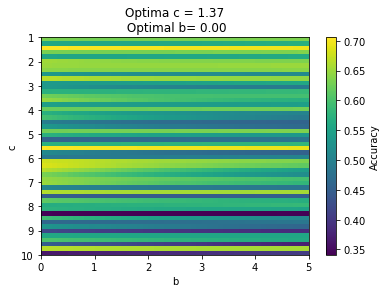

In [510]:
hypergrid={'c':np.linspace(1,10),'b':np.linspace(0,5)}
Params, Results = cv_svm_RBF(X,y,T=5,hypergrid=hypergrid)
fig, ax = plt.subplots(1,1)
img = ax.imshow(Results,extent=[hypergrid['b'].min(), 
                                hypergrid['b'].max(), 
                                hypergrid['c'].max(), 
                                hypergrid['c'].min()], aspect='auto')
op_index= np.argmax(Results)
c_op, b_op = Params[op_index]
_ = fig.colorbar(img,label='Accuracy')
_ = plt.title(f"Optima c = {c_op:.2f}\n Optimal b= {b_op:.2f}")
_ = ax.set_xlabel("b")
_ = ax.set_ylabel("c")

In [511]:
RBF_K = lambda x1, x2: np.exp(-np.linalg.norm(x1-x2)**2/ c_op)
W,b, alpha = svm_dual(X,y,RBF_K,r_strength=1e12,precision=1e1,max_iter=1000)
y_hat  = predict_svm_kernel(W,b_op,X)
yt_hat = predict_svm_kernel(W,b_op,Xt)
print(f"Accuracy Training = {100*score(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*score(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Maximun number of iterations 1000 reached
Accuracy Training = 70.50%
Accuracy Test     = 68.00%
F1 Training = 70.27%
F1 Test     = 68.17%
Confusion matrix Training = 
 [[559 232]
 [  4   5]]
Confusion matrix Test = 
 [[136  63]
 [  1   0]]


We don't have a spectacular result using the kernel, we do cross validation over the 2 parameters, the free parameter or threshold b and the bandwith of the gaussian kernel. We again keep the regulation parameter high, the function implemented for solving the problem for $W$ uses a parameter for the precision for wich we want the parameter alpha, in this case that we use a big number for the regulation strength we can achive a great precision in the parameter alpha. This hard margin once again uses an aproximation coming from the soft margin the advantange of using the optimization of the dual is the kernel trick there is only one kernel involved in the optimization. If we would use the primal problem we would have to compute the derivative of the kernel (this is something I tried to avoid, not because the derivative is difficult to compute but because the idea of the kernel trick is to simply replace the inner products by the kernel)

In [644]:
def ROC(b):
    y_hat  = predict_svm_kernel(W,b,X)
    cm  =confusion_matrix(y,y_hat)
    TPR = cm[0,0] / (cm[0,0] + cm[1,0]+0.0000001)
    FPR = 1 - cm[1,1] / (cm[1,1]+cm[0,1]+0.0000001)
#     print(cm)
    return(np.array([TPR,FPR]))

In [645]:
ROCc = []
for b in np.linspace(-10,10,200):
    ROCc.append(ROC(b))
ROCc = np.array(ROCc).T

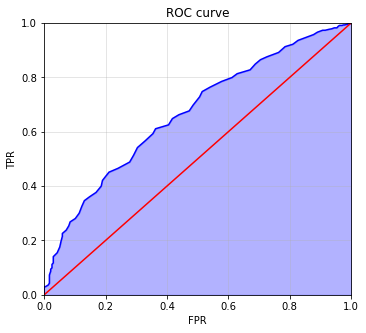

In [646]:
plt.figure(figsize=(5.5,5))
plt.title("ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0,1)
plt.ylim(0,1)
plt.fill_between(ROCc[1,:],ROCc[0,:],color='b',alpha=0.3)
plt.plot(ROCc[1,:],ROCc[0,:],color='b')
# plt.scatter(ROCc[1,:],ROCc[0,:],color='k')
plt.plot([0,1],[0,1],color='red')
plt.grid(alpha=0.4)

### 3.1 Sigmoid Support Vector Machine 
For the implementation of the sigmoid we did't succed in use the previous algorithm, we go back to the code seen in class. We focus in doing the optimization task over the primal problem using gradient descent.

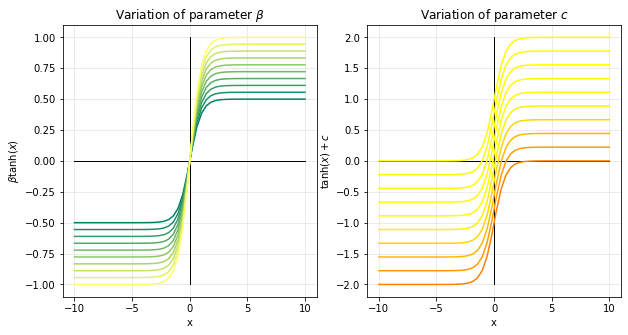

In [1038]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(np.linspace(-10,10),[0 for x in np.linspace(-10,10)],color='k',lw=1)
ax1.plot([0 for x in np.linspace(-10,10)],np.linspace(-1,1),color='k',lw=1)
for beta in np.linspace(0.5,1,10):
    ax1.plot(np.linspace(-10,10),[beta*np.tanh(x) for x in np.linspace(-10,10)],color=plt.cm.summer(2*beta-1))
ax1.grid(alpha=0.3)
ax1.set_title("Variation of parameter $\\beta$")
ax2.plot(np.linspace(-10,10),[0 for x in np.linspace(-10,10)],color='k',lw=1)
ax2.plot([0 for x in np.linspace(-10,10)],np.linspace(-2,2),color='k',lw=1)
for c in np.linspace(-1,1,10):
    ax2.plot(np.linspace(-10,10),[np.tanh(x) + c for x in np.linspace(-10,10)],color=plt.cm.autumn(0.5*c+1))
ax2.set_title("Variation of parameter $c$")
ax2.set_xlabel("x")
ax2.set_ylabel("$\\tanh(x) + c$")
ax1.set_ylabel("$\\beta\\tanh(x)$")
ax1.set_xlabel("x")
ax2.grid(alpha=0.3)

Knowing the range of the sigmoid function we can know where to look for the parameter $b$ to optimize the prediction $y = \text{sign}(k(x,W)+b)$

The computations of the cost and the gradient that we have to take at each step we need the following formulas: 
$$K(x,y) =\beta \text{ tanh}(\langle x,y\rangle) + c$$

$$\frac{d}{d\boldsymbol w}K(\boldsymbol w,x)  = \beta x(1-\text{ tanh}^2(\langle \boldsymbol w,x\rangle)) $$

$$K(\boldsymbol w,\boldsymbol w) =\beta \text{ tanh}(\| \boldsymbol w\|^2) + c $$

$$\frac{d}{d\boldsymbol w}K(\boldsymbol w,\boldsymbol w)  = 2\beta x  (1-\text{ tanh}^2(\langle \boldsymbol w,x\rangle)) $$

$$
\mathcal L (\boldsymbol w) = \frac{1}{2}K( \boldsymbol w, \boldsymbol w) + \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, 1-y_i (K(\boldsymbol w , x_i) + b) \bigg) \, .
$$

$$
\nabla\mathcal L (\boldsymbol w) = \beta \boldsymbol w(1-\text{ tanh}^2(\langle \boldsymbol w, \boldsymbol w\rangle) + x\beta \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, -y_i (1-\text{ tanh}^2(\langle \boldsymbol w, \boldsymbol x\rangle)) \bigg) \, .
$$

$$
\boldsymbol w = \boldsymbol w  - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$

In [1100]:
sigmoid = lambda x1, x2,beta,c: beta * np.tanh(np.dot(x1,x2)) + c
def compute_cost(W, X, y,beta,c, regul_strength=1e5):
    """
    Computes the cost of the parameters W
    given the data X,y and the regulation
    strength 
    
    :param W: a Dx1 numpy array
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param regul_strength: a float
    
    :return cost: a float
    """
    n = X.shape[0]
    distances = np.zeros((n))
    for i in range(n):
        distances[i] = 1 - y[i] * sigmoid(X[i,:],W,beta,c) #replaced inner product by kernel
    distances[distances < 0] = 0 
    hinge = regul_strength * (np.sum(distances) / n) #replaced inner product by kernel

    cost = 1 / 2 *  sigmoid(W,W,beta,c) + hinge
    return cost
def calculate_cost_gradient(W, X, y,beta,c,regul_strength=1e5):
    """
    Compute the gradient of the cost 
    function given the value of the parameter
    and the data.
    
    :param W: a Dx1 numpy array
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param regul_strength: a float
    
    :return dw: a Dx1 numpy array
    """
    
    if type(y) == np.int64:
        y = np.asarray([y])
        X = np.asarray([X])  
        
    n = X.shape[0]    
    distances = np.zeros((n))
    for i in range(n):
        distances[i] = 1 - y[i] * sigmoid(X[i,:],W,beta,c) #replaced inner product by kernel
    dw = np.zeros(len(W))
    
    for ind, d in enumerate(distances):
        if max(0, d)==0:
            di = W * (1 - np.tanh(np.linalg.norm(W))**2) * beta # derivative of the kernel 
        else:
            di =  W*(1 - np.tanh(np.linalg.norm(W))**2)*beta - (regul_strength*y[ind]*X[ind] * (1 - np.tanh(np.dot(W,X[ind]))**2) * beta)
        dw += di

    dw = dw/len(y)
    return dw

def sigmoid_svm_sgd(X, y,beta,c, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e5, print_outcome=False):
    """
    Computes the optimal parameter W using 
    stochastic gradient descent for the data X,y, 
    and given the learning rate, regulation strength 
    parameter, stop criterion and the maximun number 
    of iterations
    
    :param X: a DxN numpy array
    :param y: a Nx1 numpy array
    :param max_iterations: a integer
    :param stop criterion: a float
    :param learning_rate: a float
    :param regul_strength: a float
    :param print_outcome: a boolean
    
    :return weights: a Dx1 numpy parameter    
    """
    weights = np.zeros(X.shape[1])
    nth = 0

    prev_cost = np.inf

    for iteration in range(1, max_iterations):
        np.random.shuffle([X, y])
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, y[ind],beta,c, regul_strength) 
            weights = weights - (learning_rate * ascent)

        if iteration==2**nth or iteration==max_iterations-1:

            cost = compute_cost(weights, X, y,beta,c,regul_strength) 
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))

            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
          
            prev_cost = cost
            nth += 1
  
    return weights
def predict_svm(W,X,beta,c,b):
    """ 
    Given a array of parameters W computes
    the prediction for the dataset X
    
    :param W: a Dx1 numpy array
    :param X: a NxD numpya array
    
    :return y_pred: a Nx1 numpy array
    """
    
    y_preds = np.array([])
    for i in range(X.shape[0]):
        y_pred = np.sign(sigmoid(X[i], W,beta,c)+ b)
        y_preds = np.append(y_preds, y_pred)
    return(np.array(y_preds))
def cv_svm_sigmoid(X,y,T,hypergrid):
    """
    Finds the best selection of hyperparameters
    for the data set X,y using T-folds for the 
    SVM model classification using the sigmoid
    kernel
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param hypergrid: a dictionary with parameters
    
    :return op_params: a tuple - the optimal parameters
    :return Results: a LxJ numpy array
    """     
    Xs,ys = data_split(X,y,T)
    Results = np.zeros((len(hypergrid['c']),len(hypergrid['beta'])))
    Params =np.array([(c,b) for c in hypergrid['c'] for b in hypergrid['beta']])
    for i,c in enumerate(hypergrid['c']):
        for k,beta in enumerate(hypergrid['beta']):
            acc_s = []
            for t in range(T):
                Xcs = np.concatenate([x for i,x in enumerate(Xs) if i!=t])
                ycs = np.concatenate([y for i,y in enumerate(ys) if i!=t])
                W = sigmoid_svm_sgd(Xcs, ycs,beta,c, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-2, regul_strength=1)
                scores = []
                ## We look for the values of b that make sense for the fitted parameter
                for b in np.linspace(-c,c):
                    ycs_hat =predict_svm(W,Xs[t],beta,c,b)
                    scores.append(F1score(ys[t],ycs_hat))
                acc_s.append(max(scores))
            Results[i,k] = np.mean(acc_s) 
        
    return(Params, Results)

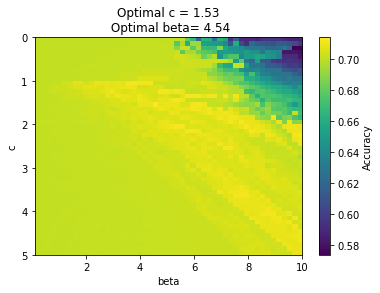

In [1118]:
hypergrid = {'c':np.linspace(0,5),'beta':np.linspace(0.1,10)}
Params, Results = cv_svm_sigmoid(X,y,5,hypergrid)
fig, ax = plt.subplots(1,1)
img = ax.imshow(Results,extent=[hypergrid['beta'].min(), 
                                hypergrid['beta'].max(), 
                                hypergrid['c'].max(), 
                                hypergrid['c'].min()], aspect='auto')
op_index= np.argmax(Results)
c_op, beta_op = Params[op_index]
_ = fig.colorbar(img,label='Accuracy')
_ = plt.title(f"Optimal c = {c_op:.2f}\n Optimal beta= {beta_op:.2f}")
_ = ax.set_xlabel("beta")
_ = ax.set_ylabel("c")

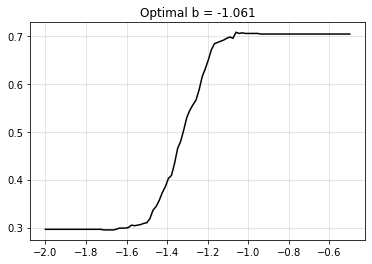

In [1196]:
W = linear_svm_sgd(X, y,beta_op,c_op, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-2, regul_strength=1)
scores = []
## We look for the values of b that make sense for the fitted parameter
values =np.linspace(-2,-0.5,100)
for b in values:
    ys_hat =predict_svm(W,X,beta_op,c_op,b)
    scores.append(score(ys_hat,y))
b_op = values[np.argmax(scores)]
plt.title(f"Optimal b = {b_op:.3f}")
plt.plot(values,scores,color='k')
plt.grid(alpha=0.4)

We optimize the value of $b$ after the crossvalitadion, we indirectely do that in the cross valitadion, but the especific value for the parameter $b$ where the score is maximize was not returned. 

In [1185]:
y_hat = predict_svm(W,X,beta_op,c_op,b_op)
yt_hat = predict_svm(W,Xt,beta_op,c_op,b_op)
print(f"Accuracy Training = {100*score(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*score(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Accuracy Training = 70.75%
Accuracy Test     = 68.50%
F1 Training = 70.17%
F1 Test     = 68.02%
Confusion matrix Training = 
 [[554 225]
 [  9  12]]
Confusion matrix Test = 
 [[134  60]
 [  3   3]]


There results are not incredible for this model, almost all predictions goes to the 1 category, we can see that in the confusion matrix, we didn't optimize over the regulation paramter due to the computation time, the code for one single cross valitadion tool half an hour 

#### Hard Margin Sigmoid

In [1187]:
def cv_svm_sigmoid(X,y,T,hypergrid):
    """
    Finds the best selection of hyperparameters
    for the data set X,y using T-folds for the 
    SVM model classification using the sigmoid
    kernel
    
    :param X: an NxD numpy array
    :param y: an Mx1 numpy array
    :param T: an integer 
    :param hypergrid: a dictionary with parameters
    
    :return op_params: a tuple - the optimal parameters
    :return Results: a LxJ numpy array
    """     
    Xs,ys = data_split(X,y,T)
    Results = np.zeros((len(hypergrid['c']),len(hypergrid['beta'])))
    Params =np.array([(c,b) for c in hypergrid['c'] for b in hypergrid['beta']])
    for i,c in enumerate(hypergrid['c']):
        for k,beta in enumerate(hypergrid['beta']):
            acc_s = []
            for t in range(T):
                Xcs = np.concatenate([x for i,x in enumerate(Xs) if i!=t])
                ycs = np.concatenate([y for i,y in enumerate(ys) if i!=t])
                W = sigmoid_svm_sgd(Xcs, ycs,beta,c, max_iterations=2000, learning_rate=1e-2, regul_strength=1e10)
                scores = []
                ## We look for the values of b that make sense for the fitted parameter
                for b in np.linspace(-c,c):
                    ycs_hat =predict_svm(W,Xs[t],beta,c,b)
                    scores.append(F1score(ys[t],ycs_hat))
                acc_s.append(max(scores))
            Results[i,k] = np.mean(acc_s) 
        
    return(Params, Results)

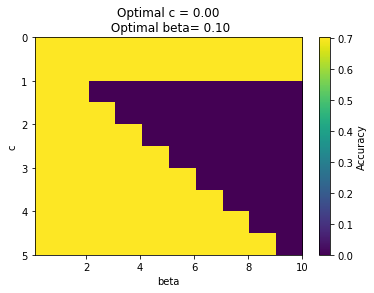

In [1192]:
hypergrid = {'c':np.linspace(0,5,10),'beta':np.linspace(0.1,10,10)}
Params, Results = cv_svm_sigmoid(X,y,5,hypergrid)
fig, ax = plt.subplots(1,1)
img = ax.imshow(Results,extent=[hypergrid['beta'].min(), 
                                hypergrid['beta'].max(), 
                                hypergrid['c'].max(), 
                                hypergrid['c'].min()], aspect='auto')
op_index= np.argmax(Results)
c_op, beta_op = Params[op_index]
_ = fig.colorbar(img,label='Accuracy')
_ = plt.title(f"Optimal c = {c_op:.2f}\n Optimal beta= {beta_op:.2f}")
_ = ax.set_xlabel("beta")
_ = ax.set_ylabel("c")

Almost not dependance in the parameters due to the size of $W$

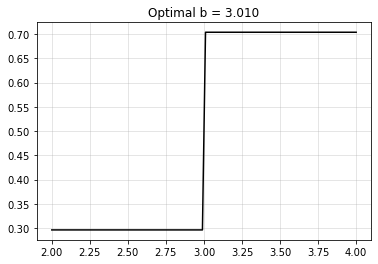

In [1201]:
W = linear_svm_sgd(X, y,beta_op,c_op, max_iterations=2000, stop_criterion=0.01, learning_rate=1e10, regul_strength=1)
scores = []
## We look for the values of b that make sense for the fitted parameter
values =np.linspace(2,4,100)
for b in values:
    ys_hat =predict_svm(W,X,beta_op,c_op,b)
    scores.append(score(ys_hat,y))
b_op = values[np.argmax(scores)]
plt.title(f"Optimal b = {b_op:.3f}")
plt.plot(values,scores,color='k')
plt.grid(alpha=0.4)

In [1203]:
y_hat = predict_svm(W,X,beta_op,c_op,b_op)
yt_hat = predict_svm(W,Xt,beta_op,c_op,b_op)
print(f"Accuracy Training = {100*score(y,y_hat):.2f}%")
print(f'Accuracy Test     = {100*score(yt,yt_hat):.2f}%')
print(f"F1 Training = {100*F1score(y,y_hat):.2f}%")
print(f'F1 Test     = {100*F1score(yt,yt_hat):.2f}%')
print("Confusion matrix Training = \n",confusion_matrix(y,y_hat))
print("Confusion matrix Test = \n",confusion_matrix(yt,yt_hat))

Accuracy Training = 70.38%
Accuracy Test     = 68.50%
F1 Training = 70.37%
F1 Test     = 68.50%
Confusion matrix Training = 
 [[563 237]
 [  0   0]]
Confusion matrix Test = 
 [[137  63]
 [  0   0]]


In [1255]:
W


array([-7.34411765e+09, -1.13500000e+10, -1.64872895e+10, -1.13500000e+10,
        0.00000000e+00,  0.00000000e+00, -1.51333333e+10, -1.51333333e+10,
       -1.21607143e+10, -4.54000000e+10, -4.54000000e+10])

Using cross validation using a large regulation strength, in order to get the hard margin of the classifier, we couldn't get higher accuracy, the size of $W$ is large, so the dependance in the parameters $\beta$ and $c$ is low. All the predictions goes to the 1's, we can see in the confusion matrix, the model does not generalize. 